In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [2]:
samples = [
    "DYJetsToLL_M10to50",
   "DYJetsToLL_M50"
]
fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=16) #CHANGED: background appears to use v2 ntuples instead of v4

In [3]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "2mu2e","4mu",
            "baseNoLj"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.
p = sidm_processor.SidmProcessor(
    channels, ["base"]) # not sure if base_plus_gen applies to the background

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

# Overall, this takes the samples listed in "samples" (section [2]), then processes them in the sidm_processor function.
# Without actual background data, I'm not sure of the format I should use for the samples, or whether the "base_plus_gen" set applies here.
# Regardless, the histograms generated should be stored in the variable "out".

Output()

Output()

Not applying any cuts to the lepton jets for channel  baseNoLj
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   muons :  looseID
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  ifcsczero
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  segOverlap < 0.66
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuon

In [4]:
output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["DYJetsToLL_M10to50"]["cutflow"]["2mu2e"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["DYJetsToLL_M10to50"]["cutflow"]["baseNoLj"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection                73.7         73.7
PV filter                   73.7         73.7
Cosmic veto                 73.7         73.7
>=2 LJs                      0.0          0.0
4mu                          0.0          0.0

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection                73.7         73.7
PV filter                   73.7         73.7
Cosmic veto                 73.7         73.7
>=2 LJs                      0.0          0.0
2mu2e                        0.0          0.0

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection                73.7         73.7
PV filter                   73.7         73.7
Cosmic veto                 73.7         73.7



In [7]:
output['out']["DYJetsToLL_M50"]["cutflow"]["4mu"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["DYJetsToLL_M50"]["cutflow"]["2mu2e"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()
output['out']["DYJetsToLL_M50"]["cutflow"]["baseNoLj"].print_table()
#output['out']["DYJetsToLL_M10to50"]["cutflow"]["4mu"].print_table(fraction=True)
print()

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection               715.6        715.6
PV filter                  715.6        715.6
Cosmic veto                715.6        715.6
>=2 LJs                      1.8          1.8
4mu                          0.0          0.0

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection               715.6        715.6
PV filter                  715.6        715.6
Cosmic veto                715.6        715.6
>=2 LJs                      1.8          1.8
2mu2e                        1.7          1.7

cut name        individual cut N    all cut N
------------  ------------------  -----------
No selection               715.6        715.6
PV filter                  715.6        715.6
Cosmic veto                715.6        715.6



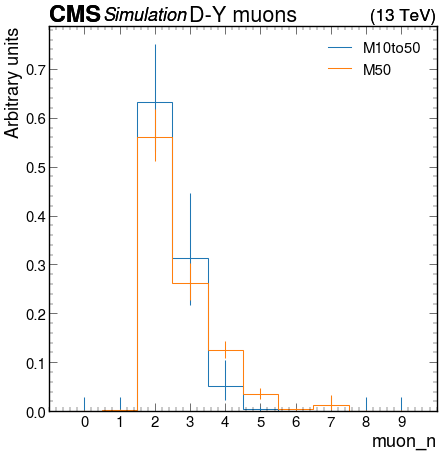

In [5]:
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_n"][channels[2], :], density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
    plt.legend(["M10to50", "M50"])
    plt.title("D-Y muons")

/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/p

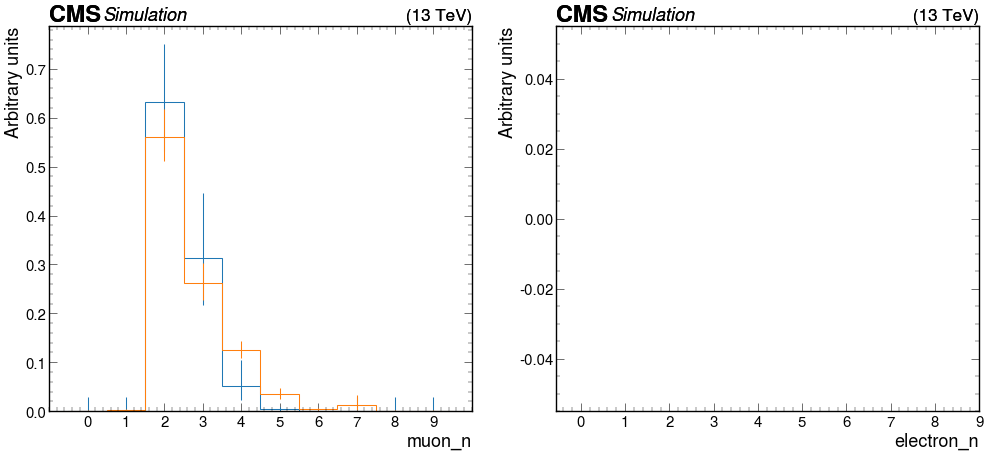

In [6]:
nplots = 2
plt.subplots(1, nplots, figsize=(nplots*12, 10))
plt.subplot(1, nplots, 1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_n"][channels[2], :], density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")
plt.subplot(1, nplots, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["electron_n"][channels[2], :], density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylabel("Arbitrary units")

In [14]:
utilities.plot(out["DYJetsToLL_M50"]["hists"]["genMu0_pt_highRange"][channels[0], :], density=True)
#utilities.plot(out[sample]["hists"]["genE1_pt_highRange"][channels[0], :600j], density=True) 

KeyError: 'genMu0_pt_highRange'